# Multi-channel speech enhancement and beamforming


Simple, single-channel [noise attenuation](Noise_attenuation) and
dereverberation is often not sufficient for acceptable quality,
especially in very noisy environments, such as in a car or on a busy
sidewalk. To reach better quality, we can then add more microphones. The
benefit of added microphones includes at least:

-   Time-of-arrival differences between sources enables the use of
    beamforming filters, which use such time (phase) differences to
    separate between sources.
-   Intensity level differences between sources; In for example a mobile
    phone, we can have forward and backward facing microphones such that
    the backward facing microphone is used primarily for estimating
    background noise, while the forward facing microphone records the
    desired speech signal. By using the background-noise estimate from
    the backward facing microphone, we can then use noise attenuation on
    the forward facing microphone to gain better quality.
-   Each microphone will feature some level of sensor-noise, that is,
    the hardware itself causes some inaccuracies to the signal.
    Sensor-noises are for most parts independent across microphones such
    that with each additional microphone we can better separate desired
    sources from noise.

The most-frequently discussed approach is to use microphone arrays,
typically in either a linear configuration, where microphones are
equi-spaced on a straight line, or in a circular configuration, where
microphones are equi-spaced on a circle. The benefits include that a
linear configuration makes analytical analysis easier, whereas a
circular array can have an almost uniform response in all directions.

{cite}`benesty2008springer`

## Delay-and-sum beamforming

As an introduction to beamforming consider a linear array of $K$
microphones with input signals $x_{k}(t)$, where $k$ and $t$ are
the microphone and time indices. We assume that the desired source is
sufficiently far away that we can approximate it with a plane wave. Then
the signal will arrive at the microphones at different times  $
\Delta t_{x_k} $ and we can calculate time [time difference of
arrival (TDOA)](tdoa.ipynb) of each microphone $ t_{x_k} = \Delta
t_{x_k}-\Delta t_{x_1} $ where we used microphone $k=1$ as a
reference point. The delayed signals thus have $ x_k(t) = x(t-\Delta
t_{x_k}) = x\left(t-\Delta t_{x_k}+\Delta t_{x_1} - \Delta
t_{x_1}\right) = x_1(t-t_{x_k}). $ Similarly, for the noise sources
we have $ y_k(t) = t_1(t-t_{y_k}). $  

If the desired and noise sources appear at different angles, then their
corresponding delays will be different. Moreover, if we add a
signal $z(t)$ with itself at a random offset δ, then the summation is
destructive, that is, smaller than the original $
\frac12\left\|z(t)+z(t+\delta)\right\| \leq \left\|z(t)\right\|
$ . Addition without an offset is obviously constructive, such that we
can form the *delay and sum estimate* as

$$ \hat x(t) = \frac 1K \sum_{k=1}^K x_k(t-t_{x_k}). $$

In this summation, all signals approaching from the same direction as
the desired source will be additive (constructive) and other directions
will be (more or less) destructive.

Trivial as it is, the delay-and-sum should however be treated as a
pedagogical example only. It does not ideally amplify the desired source
nor attenuate the noise source, and it is sensitive to errors in the
TDOAs.


![delayandsum.png](attachments/175509409.png)

### Demonstration

Let us import the usual Python packages for scientific programming: numpy for numerical computing, matplotlib for plotting, and our own DSB_Tools (imported as dsb), and define our constant c0 for the speed of sound:

In [1]:
# package for numeric computing
import numpy as np

# package for basic plotting
from matplotlib import pyplot as plt

# package for beamforming basics
import DSB_Tools as dsb

# speed of sound
c0 = 1500.

#### Create vector of time samples

We now define the necessary variables to create a vector t of time-domain samples, of duration T seconds and sampling frequency fs Hz:

In [2]:
fs = 48e3       # sampling freq [Hz]
dt = 1./fs      # temporal resolution [s]
T = 0.5           # length of recording [s]

N_time = int(T*fs)

# vector of time samples
t = np.linspace(0, T-dt, N_time)

#### Create the uniform linear array (ULA)
Onwards to our Uniform Linear Array: the DSB_Tools package allows us to create a uniform linear array (ULA) by calling the function dsb.SensorArray(L, M), where L is the array length in meters and M is the number of sensors (here we assume M is always odd for simplicity). Note that, upon successful creation of our ULA, the function will automatically print the inter-sensor spacing for this array:

In [3]:

# Array length [m]
L = 1.4     
# Number of sensors in the uniform linear array (ULA) 
M = 15      
#Our array definition is stored in the object ULA
ULA = dsb.SensorArray(L, M)

Array inter sensor spacing is 0.09999999999999999 m


#### Create the source signal.
We will use the function dsb.create_narrowband_pulse to create a signal with center frequency f0, amplitude a0 and duration T_pulse. 

In [4]:
# define pulse characteristics: amplitude, duration, onset time, center frequency
a0 = 1.
T_pulse = 0.002      # [s]
N_pulse = int(T_pulse*fs)

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# narrowband pulse center frequency - try other values!

f0 = 5000            # [Hz]
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

x_pulse = dsb.create_narrowband_pulse(a0, T_pulse, f0, fs)

# acoustic wavelength of pulse center freq
ac_wavelength = c0/f0
print(ac_wavelength/2)
print(ULA.d)
print("Acoustic wavelength for f0 = {} Hz is {} m".format(f0, ac_wavelength))

# check for spatial aliasing condition
if ULA.d >= ac_wavelength/2:
    print('\tCareful --> Aliasing might occur!')

0.15
0.09999999999999999
Acoustic wavelength for f0 = 5000 Hz is 0.3 m


#### Choose one direction of arrival (DoA)
theta0_deg for our incoming plane wave containing the narrowband pulse, the onset time t_initial for the pulse, and a signal-to-noise ratio (SNR) in decibels for the array signals.

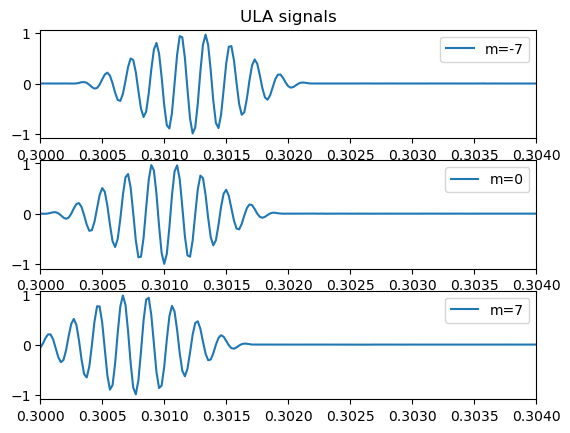

In [5]:
# create array of sensor signals from a given direction of arrival

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# direction of arrival of narrowband pulse, in degrees
# --> try any value between 0 and 180
theta0_deg = 60.

# signal-to-noise ratio at array signal
# --> 'None' means no noise is present
# --> 60 dB means very little noise is present
# -->  0 dB means signal and noise have the same power 

SNR_dB = 60
# onset time of narrowband pulse
t_initial = 0.3

p_array = dsb.create_array_signals(ULA, x_pulse, t_initial, T, theta0_deg, fs, c0, SNR_dB)

#Inspect the resulting data by ploting the signals for the first, the middle and the last sensors in our ULA:
plt.figure()
m_index = [0, int((M-1)/2), M-1]
for m in range(3):
    plt.subplot(3, 1, m+1)
    
    if m == 0:
        plt.title('ULA signals')
    plt.plot(t, p_array[m_index[m],:], label='m={}'.format(m_index[m]-M//2))
    plt.xlim([t_initial, t_initial+2*T_pulse])
    plt.legend()
  

#### Plot a plane wave acoustic field at the same frequency and DoA as the  created narrowband pulse.

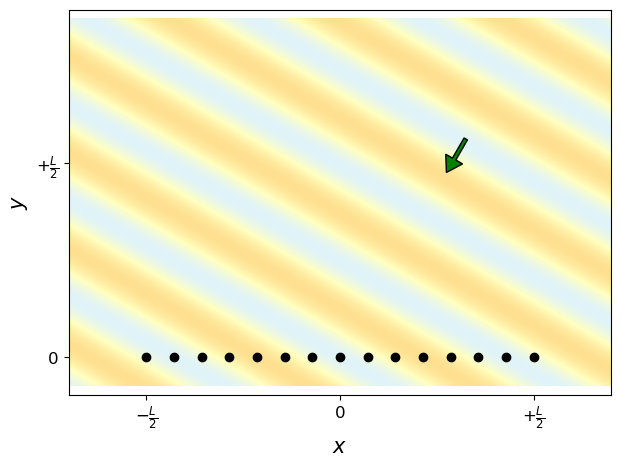

In [6]:
# Create 2D mesh of (x, y) points
mesh_side1 = np.linspace(-0.7*L, 0.7*L, 1400)
mesh_side2 = np.linspace(-0.475*L, 0.475*L, 950)
XY_mesh = np.array(np.meshgrid(mesh_side1, mesh_side2))

XY_mesh[1] += 0.4*L

# create acoustic wavenumber vector, pointint at the DIRECTION OF PROPAGATION
# of the plane wave (opposite to the DIRECTION OF ARRIVAL!)
k0 = 2*np.pi/ac_wavelength
theta0 = theta0_deg*np.pi/180.
k_vec = k0*np.array([-np.cos(theta0), -np.sin(theta0)])

# create plane wave acoustic field
p_planewave = np.exp(-1j*np.tensordot(k_vec, XY_mesh, axes=(0,0)))

# plot acoustic field and array positions
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.pcolormesh(XY_mesh[0], XY_mesh[1], p_planewave.real, cmap='RdYlBu',
              shading='nearest', vmin=-5, vmax=+5)
ax.plot(ULA.XY[0], ULA.XY[1], 'ko')
ax.set_xlabel(r'$x$', fontsize=15)
ax.set_xticks(ticks=np.array([-0.5, 0., 0.5])*L)
ax.set_xticklabels([r'$-\frac{L}{2}$', r'$0$', r'$+\frac{L}{2}$'],
                   fontsize=12)
ax.set_ylabel(r'$y$', fontsize=15)
ax.set_yticks(ticks=np.array([0., 0.5])*L)
ax.set_yticklabels([r'$0$', r'$+\frac{L}{2}$'], fontsize=12)
ax.axis('equal')

# indicate direction of propagation of plane wave with a green arrow
ax.arrow(0.65*L*np.cos(theta0), 0.65*L*np.sin(theta0),
         -0.1*L*np.cos(theta0), -0.1*L*np.sin(theta0),
         width=0.01*L, head_width=0.05*L, head_length=0.04*L,
         length_includes_head=True, edgecolor = 'k', facecolor = 'g')


#### Calculate the delay-and-sum beamformer, 
we need a vector of steering angles theta (DoA) to steer our array towards. Let's define a range of N_theta points covering the entire [0, 180] degrees range. 

We need also to define the vector of amplitude shading weights

The actual beamforming calculation is performed via the function dsb.delayandsum_beamformer, which takes as arguments the object containing the ULA geometry, the sensor signals, the vector of look directions, and the sampling frequency.

In [7]:
# use delay-and-sum beamforming to map direction of arrival

N_theta = 181
theta = np.linspace(0, np.pi, N_theta)

N_DoA = int(theta0_deg) # choosed above 

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
## array shading schemes - uncomment one
weights = np.ones(M)
# weights = ss.windows.hann(M)
# weights = ss.windows.chebwin(M, 40)
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

y_beamformer = dsb.delayandsum_beamformer(ULA, p_array, theta, weights, fs)

#### Plot the beamformer output y(theta, t) 
for a few candidate steering directions - say, 0 deg, 45 deg and 90 deg. If the steering direction matches the direction of arrival `theta0` of the plane wave, you should see a large amplitude pulse; otherwise, destructive interference between the misaligned sensor signals will yield a low amplitude result - or perhaps even zero!

It is very interesting to compare the beamformer output y(t) to the signal captured by the center sensor p0(t). The second figure was created so that it superimposes the center sensor signal to the beamformer output when the steering direction matches the plane wave DoA. Note how the beamformer output has significantly less noise than the single sensor.

Text(0.5, 1.0, 'Center sensor vs. beamformer output')

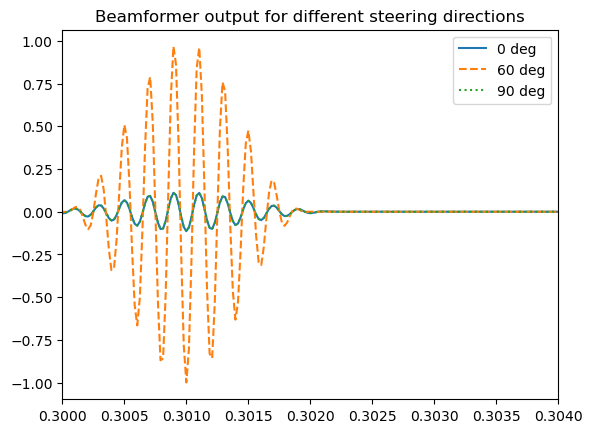

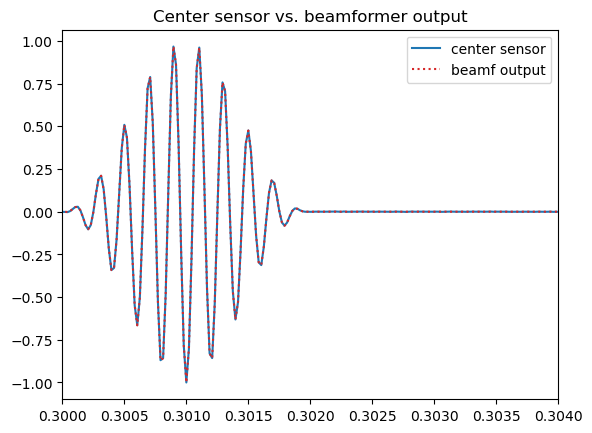

In [8]:
# plot beamformer output for different steering directions
plt.figure()
plt.plot(t, y_beamformer[0, :], label='0 deg')
plt.plot(t, y_beamformer[60, :], '--', label='60 deg')
plt.plot(t, y_beamformer[90, :], ':', label='90 deg')
plt.xlim([t_initial, t_initial+2*T_pulse])
plt.legend()
plt.title('Beamformer output for different steering directions')


# compare beamformer output to center sensor signal
plt.figure()
plt.plot(t, p_array[M//2, :], label='center sensor')
plt.plot(t, y_beamformer[N_DoA, :], ':', label='beamf output', color='C3')
plt.xlim([t_initial, t_initial+2*T_pulse])
plt.legend()
plt.title('Center sensor vs. beamformer output')

#### Create beamformer polar response.


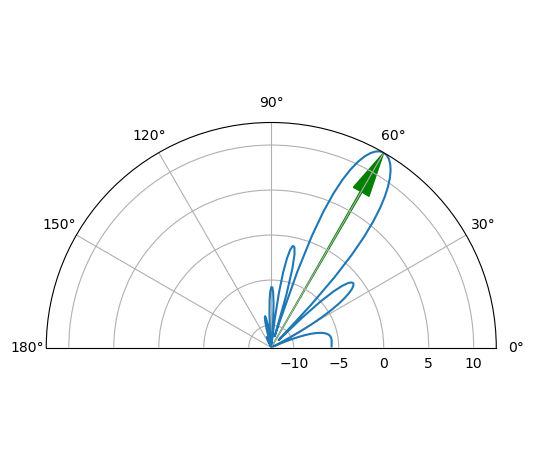

In [9]:
# Create beamformer polar plot

y_beamf_polar = np.sum(y_beamformer**2, axis=1)

y_beamf_polar_dB = 10*np.log10(y_beamf_polar)
dB_max = y_beamf_polar_dB.max()

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Polar plot dynamic range

dyn_range = 25      # dB
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, y_beamf_polar_dB)

# add arrow indicating direction of arrival of signal
ax.arrow(theta0_deg*np.pi/180, dB_max-dyn_range, 0, dyn_range, width=0.01,
         head_width=0.1, head_length=5,
         length_includes_head=True, edgecolor = 'green', facecolor = 'green')

ax.set_rmax(dB_max)
ax.set_rmin(dB_max - dyn_range)

ax.set_thetamin(0)
ax.set_thetamax(180)
fig.set_tight_layout(True)

## References


```{bibliography}
:filter: docname in docnames
```